In [95]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

import os
# os.chdir(r'E:\workspace\ai\ml_utils\proj\RRVF')
os.chdir(r'/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF')
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
from keras.models import model_from_yaml
import utils
# import xgboost
import random
from importlib import reload
reload(utils)
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))


In [47]:
hol = pd.read_csv('{}/date_info.csv'.format(data_dir))
hol = hol.rename(
    {
        'calendar_date': 'Date',
    }, axis='columns')
hol.Date = pd.to_datetime(hol.Date)
hol = utils.add_ts_elapsed('holiday_flg', ['dur_'], hol)
calender = hol[['Date', 'holiday_flg', 'dur_holiday_flg']]
prophit_hol = calender[calender.holiday_flg == 1].rename({
    'dur_holiday_flg': 'holiday',
    'Date': 'ds'
},axis="columns").drop('holiday_flg', axis=1)
prophit_hol.holiday = prophit_hol.holiday.astype('str')

In [88]:
a_store_df = trn[trn.air_store_id == 'air_9438d67241c81314']


In [101]:
model_zoo = {}
def trn2prop(trn):
    prop = trn.drop('air_store_id', axis=1).rename({
        'visit_date': 'ds',
        'visitors': 'y'
    },axis="columns")
    prop.y = np.log(prop['y'])
    return prop


def fit_func(trn):
    model_key = trn.air_store_id.unique().tolist()[0]
    prop = trn2prop(trn)
    model_zoo[model_key] = None
    m = Prophet(holidays=prophit_hol, yearly_seasonality=False, daily_seasonality=False)
    m.fit(prop)
    model_zoo[model_key] = m
    return None

trn.groupby('air_store_id').apply(fit_func)

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 15.0.


""


In [108]:
import pickle as pkl
pkl.dump(model_zoo, open('result/prop.pkl','wb'))

In [170]:
result = pkl.load(open('result/result1.pkl', 'rb'))

In [177]:

result['air_fff68b929994bfbd']

0     3.354523
1     3.384839
2     3.727129
3     3.662222
4     3.915427
5     4.648771
6     6.366075
7     3.354561
8     3.384878
9     3.727171
10    4.030544
11    4.309214
12    5.116313
13    6.605516
14    3.354599
15    3.384916
16    3.727214
17    3.662306
18    3.915516
19    4.648877
20    6.605592
21    3.354637
22    3.384955
23    3.727256
24    3.662347
25    3.915561
26    4.648930
27    6.605667
28    3.354676
29    3.384994
30    3.727299
31    3.662389
32    3.915605
33    4.648983
34    6.605742
35    3.354714
36    3.385032
37    3.727341
38    3.662431
Name: yhat, dtype: float64

In [173]:
data_dir = r'./data'
tst = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(tst)
trn_like_test = trn_like_test.assign(visitors=0)

In [179]:
ids = trn_like_test.air_store_id.unique().tolist()
for a_store_id in ids:
    trn_like_test.loc[trn_like_test['air_store_id'] == a_store_id, 'visitors' ] = result[a_store_id].values

In [178]:
len(trn_like_test.loc[trn_like_test['air_store_id'] == 'air_fff68b929994bfbd' ])

39

In [193]:
tst['visitors'] = trn_like_test.visitors

In [196]:
tst.to_csv('result/prop.csv', index=False)

In [189]:
trn_like_test.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,2.200475
1,air_00a91d42b08b08d9,2017-04-24,22.637175
2,air_00a91d42b08b08d9,2017-04-25,24.656827
3,air_00a91d42b08b08d9,2017-04-26,30.577091
4,air_00a91d42b08b08d9,2017-04-27,32.924348


In [192]:
data_dir = r'./data'
tst = pd.read_csv('{}/sample_submission.csv'.format(data_dir))

In [195]:
tst[tst.id==0]

,id,visitors


In [ ]:
trn_like_test.loc[trn_like_test['air_store_id'] == 'air_fff68b929994bfbd' ] = 

In [109]:
data_dir = r'./data'
tst = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(tst)
trn_like_test = trn_like_test.assign(visitors=0)

In [118]:
def pred_func(data_df):
    model_key = data_df.air_store_id.unique().tolist()[0]
    model = model_zoo[model_key]
    prop = trn2prop(data_df).drop('y',axis=1)
    data_df['pred'] = model.predict(prop)['yhat']
    return data_df

result = trn_like_test.groupby('air_store_id').apply(pred_func)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [115]:
trn_like_test.head()

,air_store_id,visit_date,visitors,predicted
0,air_00a91d42b08b08d9,2017-04-23,0,None
1,air_00a91d42b08b08d9,2017-04-24,0,None
2,air_00a91d42b08b08d9,2017-04-25,0,None
3,air_00a91d42b08b08d9,2017-04-26,0,None
4,air_00a91d42b08b08d9,2017-04-27,0,None


In [166]:
trn_like_test[['visit_date']].to_csv('time.csv', index=False)

In [121]:
result.to_csv('result/staging.csv')

In [122]:
result.pred = np.exp(result.pred )

In [128]:
tst = pd.read_csv('result/staging.csv')

In [138]:
valid_prop.to_csv('time.csv', index=False)

In [136]:
model_zoo['air_0164b9927d20bcc3'].predict(valid_prop)['yhat']

0     1.294805
1     1.729085
2     1.965206
3     2.039216
4     2.011438
5     2.211813
6     1.287994
7     1.370301
8     1.722220
9     1.958314
10    2.032297
11    2.004491
12    2.204840
13    1.280993
14    1.363301
15    1.951314
16    2.025297
17    1.997491
18    2.197839
19    1.273993
20    1.708219
21    1.944313
22    2.018296
23    1.990491
24    2.190839
25    1.266993
26    1.349300
27    1.701219
28    1.937313
29    2.011296
30    1.983491
31    2.183839
32    1.259993
33    1.694219
34    1.930313
35    2.004296
36    1.976490
37    2.176839
38    1.252992
39    1.335300
40    1.687218
41    1.923313
42    1.997296
43    1.969490
44    2.169839
45    1.245992
Name: yhat, dtype: float64

In [90]:
trn2valid_ratio = 9
trn_size = int(len(a_store_df) * trn2valid_ratio / 10)
trn = a_store_df.iloc[:trn_size] 
valid = a_store_df.iloc[trn_size:] 

In [91]:
m = trn2prop(trn, prophit_hol)

In [92]:

valid_prop = valid[['visit_date']].rename({
        'visit_date': 'ds',
        'visitors': 'y'
    },axis="columns")
forecast = m.predict(valid_prop)

In [93]:
preded = np.exp(forecast.yhat)

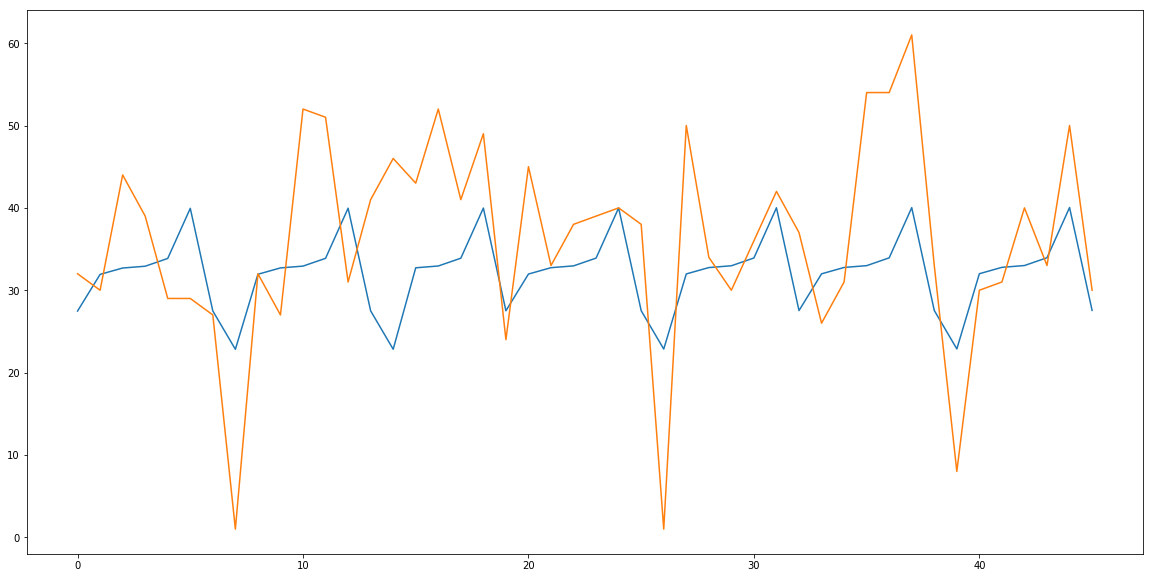

In [94]:

plt.plot(preded)
plt.plot(valid.visitors.values)

In [68]:
model_zoo['']

0     14.903022
1     18.650982
2     14.996222
3     25.554572
4     20.333872
5      2.235349
6     10.003222
7     14.708221
8     18.407191
9     14.800204
10    25.220543
11    20.068084
12     9.872468
13    14.515967
14    18.166587
15    14.606747
16    24.890881
17    19.805770
18     2.177293
19     9.743423
20    14.326226
21    17.929128
22    14.415820
23    24.565527
24    19.546885
25     9.616065
26    14.138965
27    17.694773
28    14.227387
29    24.244426
30    19.291384
31     9.490371
32    13.954152
33    17.463481
34    14.041418
35    23.927522
Name: yhat, dtype: float64

In [42]:
valid.head()

,air_store_id,visit_date,visitors
351,air_ba937bf13d40fb24,2017-03-11,26
352,air_ba937bf13d40fb24,2017-03-12,11
353,air_ba937bf13d40fb24,2017-03-13,7
354,air_ba937bf13d40fb24,2017-03-14,7
355,air_ba937bf13d40fb24,2017-03-15,21


In [37]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,1,1_lower,1_upper,2,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
351,2017-03-11,2.515049,2.515049,2.515049,2.494650,3.566966,0.000000,0.000000,0.000000,0.0,...,0.509693,0.509693,0.509693,0.509693,0.509693,0.509693,0.509693,0.509693,0.509693,3.024741
352,2017-03-12,2.513254,2.513254,2.513254,0.257663,1.354076,0.000000,0.000000,0.000000,0.0,...,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,0.823078
353,2017-03-13,2.511460,2.511460,2.511460,1.729157,2.826533,0.000000,0.000000,0.000000,0.0,...,-0.231988,-0.231988,-0.231988,-0.231988,-0.231988,-0.231988,-0.231988,-0.231988,-0.231988,2.279472
354,2017-03-14,2.509666,2.509664,2.509676,2.070080,3.145154,0.000000,0.000000,0.000000,0.0,...,0.102412,0.102412,0.102412,0.102412,0.102412,0.102412,0.102412,0.102412,0.102412,2.612078
355,2017-03-15,2.507871,2.507799,2.507949,2.274396,3.389620,0.000000,0.000000,0.000000,0.0,...,0.377904,0.377904,0.377904,0.377904,0.377904,0.377904,0.377904,0.377904,0.377904,2.885775
356,2017-03-16,2.506077,2.505933,2.506233,2.151365,3.228485,0.000000,0.000000,0.000000,0.0,...,0.196631,0.196631,0.196631,0.196631,0.196631,0.196631,0.196631,0.196631,0.196631,2.702708
357,2017-03-17,2.504283,2.504066,2.504542,2.718819,3.784413,0.000000,0.000000,0.000000,0.0,...,0.735525,0.735525,0.735525,0.735525,0.735525,0.735525,0.735525,0.735525,0.735525,3.239808
358,2017-03-18,2.502489,2.502174,2.502850,2.443081,3.565666,0.000000,0.000000,0.000000,0.0,...,0.509693,0.509693,0.509693,0.509693,0.509693,0.509693,0.509693,0.509693,0.509693,3.012181
359,2017-03-19,2.500694,2.500258,2.501170,0.232398,1.336090,0.000000,0.000000,0.000000,0.0,...,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,-1.690176,0.810518
360,2017-03-20,2.498900,2.498359,2.499570,0.642349,1.715402,-1.068758,-1.068758,-1.068758,0.0,...,-1.300746,-1.300746,-1.300746,-0.231988,-0.231988,-0.231988,-0.231988,-0.231988,-0.231988,1.198154
